In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import string
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import xgboost as xgb

In [29]:
from sklearn.preprocessing import normalize # , LabelEncoder 
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix      
from scipy import stats
from pandas.api.types import CategoricalDtype 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [30]:
gamer = pd.read_csv(r"D:\Queens University\WINTER 2020\AI\Project\PPG\\gamer1_latest.csv")
annotation=pd.read_csv(r"D:\Queens University\WINTER 2020\AI\Project\PPG\\gamer1-annotations.csv")

In [31]:
annotation.head(100)

,Datetime,Event,Value
0,2000-01-01T11:00:00,Stanford Sleepiness Self-Assessment (1-7),3
1,2000-01-01T12:00:00,Stanford Sleepiness Self-Assessment (1-7),2
2,2000-01-01T13:00:00,Stanford Sleepiness Self-Assessment (1-7),2
3,2000-01-01T14:00:00,Stanford Sleepiness Self-Assessment (1-7),2
4,2000-01-01T15:00:00,Stanford Sleepiness Self-Assessment (1-7),3
...,...,...,...
80,2000-01-02T09:16:00,Diary Entry (text),Break
81,2000-01-02T09:19:00,Diary Entry (text),Anime
82,2000-01-02T09:47:00,Diary Entry (text),Nap
83,2000-01-02T10:01:00,Diary Entry (text),Anime


In [32]:
annotation = annotation.drop(['Event'], axis=1)

In [33]:
annotation = annotation[pd.to_numeric(annotation['Value'], errors='coerce').isna()]

In [34]:
annotation['Value'].value_counts()

Break                             4
Overwatch                         3
Youtube                           3
Anime                             3
Hearthstone                       2
Lunch                             2
Bathroom                          2
Kingdom                           2
Coke                              1
Programming                       1
Tech issues                       1
End break                         1
Code and Youtube                  1
Done                              1
Dinner                            1
Headset came off                  1
Watching COD zombies              1
Stash                             1
Nap                               1
Armello                           1
Silicon valley and programming    1
Work - programming                1
Name: Value, dtype: int64

In [35]:
#ordinal encoding
map_ord1 = {'Hearthstone':0,
           'Lunch':0,
           'Youtube':0,
           'Armello':0,
           'Overwatch':0,
           'Kingdom':0,
           'Bathroom':0,
           'Stash':0,
           'Dinner':0,
           'Anime':0,
           'Work - programming':0,
           'Silicon valley and programming':0,
           'Coke':0,
           'Tech issues':0,
           'Programming':0,
           'Code and Youtube':0,
           'Watching COD zombies':0,
           'Break':1,
           'Nap':1,
           }
annotation.Value = annotation.Value.map(map_ord1)

In [36]:
annotation['Value'].value_counts()

0.0    26
1.0     5
Name: Value, dtype: int64

In [37]:
annotation['Datetime']=annotation['Datetime'].str.replace('T',' ')
annotation['minute']=annotation['Datetime'].str[0:16]
gamer['minute']=gamer['Time'].str[0:16]
df=gamer.merge(annotation, how='left',left_on='minute',right_on='minute')
columns = [ 'bpm', 'pnn20', 'pnn50', 'lf', 'hf', 'ratio','Value']
df=df[columns]

In [38]:
df.head(100)

,bpm,pnn20,pnn50,lf,hf,ratio,Value
0,68.546158,0.792208,0.581169,263.484637,434.129326,0.606927,NaN
1,75.426945,0.745098,0.607843,99.587016,209.649871,0.475016,NaN
2,64.216910,0.862069,0.672414,73.994806,241.059931,0.306956,NaN
3,69.124424,0.773585,0.566038,127.509933,181.104155,0.704070,NaN
4,64.318530,0.803279,0.540984,66.350942,154.360724,0.429843,NaN
...,...,...,...,...,...,...,...
95,71.150855,0.796610,0.593220,99.920078,217.373789,0.459669,NaN
96,70.561457,0.883333,0.766667,77.792166,203.609915,0.382065,NaN
97,70.996979,0.822222,0.755556,159.994450,175.034348,0.914075,NaN
98,68.627451,0.901639,0.786885,53.686715,230.010457,0.233410,NaN


In [39]:
annotation['Value'].value_counts()

0.0    26
1.0     5
Name: Value, dtype: int64

In [40]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [41]:
summary= resumetable(df)
summary

Dataset Shape: (1035, 7)


,Name,dtypes,Missing,Uniques,Entropy
0,bpm,float64,0,1004,9.95
1,pnn20,float64,0,381,8.07
2,pnn50,float64,0,478,8.51
3,lf,float64,0,1028,9.99
4,hf,float64,0,1031,10.00
5,ratio,float64,0,1028,9.99
6,Value,float64,1017,2,0.65


In [42]:
df = df.dropna(how='any')

In [43]:
summary2 = summary= resumetable(df)
summary2

Dataset Shape: (18, 7)


,Name,dtypes,Missing,Uniques,Entropy
0,bpm,float64,0,18,4.17
1,pnn20,float64,0,16,3.95
2,pnn50,float64,0,16,3.95
3,lf,float64,0,17,4.06
4,hf,float64,0,18,4.17
5,ratio,float64,0,17,4.06
6,Value,float64,0,2,0.65


In [44]:
# # one hot encoding
# df = pd.get_dummies(df, prefix=['Value'], columns = ['Value'])

In [45]:
columns = [ 'bpm', 'pnn20', 'pnn50', 'lf', 'hf', 'ratio']
values = ['Value']
X=df[columns]
y= df[values]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14)

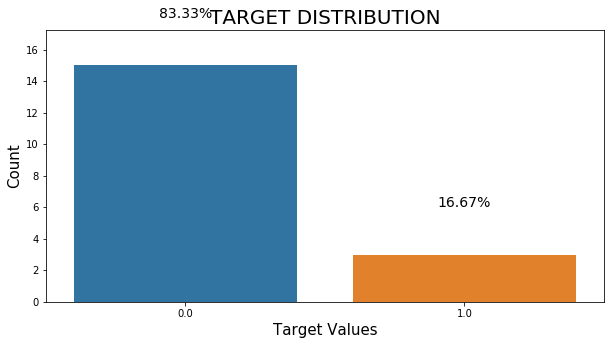

In [47]:
total = len(df)
plt.figure(figsize=(10,5))

g = sns.countplot(x='Value', data=df)
g.set_title("TARGET DISTRIBUTION", fontsize = 20)
g.set_xlabel("Target Values", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
sizes=[] # Get highest values in y
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.show()

In [48]:
# #knn
# error_rate = []
# #for i in range(1, 10):
#     knn = KNeighborsClassifier(n_neighbors=1)
#     knn.fit(X_train, y_train)
#     pred_i = knn.predict(X_test)
#     error_rate.append(np.mean(pred_i != y_test))

# plt.figure(figsize=(20,5))
# plt.plot(range(1,10), error_rate)

In [49]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4 0]
 [2 0]]
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         4
         1.0       0.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6



E:\Anaconda\envs\CISCProject\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
E:\Anaconda\envs\CISCProject\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


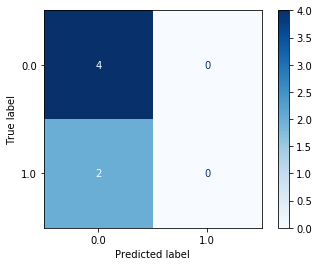

In [50]:
plot_confusion_matrix(knn, X_test, y_test, include_values= True,
                                 cmap=plt.cm.Blues)

In [51]:
#Artificial Neural Network
ann = MLPClassifier(learning_rate = 'adaptive')
ann.fit(X, y)
print(ann.score(X_train,y_train))
predictions = ann.predict(X_test)  # predict the target of testing samples
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.8333333333333334
Accuracy: 100.00%


E:\Anaconda\envs\CISCProject\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


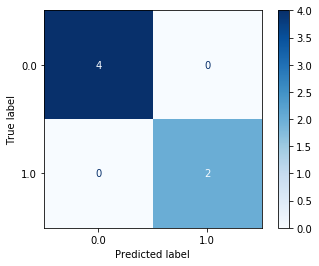

In [60]:
plot_confusion_matrix(ann, X_test, y_test, include_values= True,
                                 cmap=plt.cm.Blues)

In [53]:
#XGBoost
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
predictions = [value for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

E:\Anaconda\envs\CISCProject\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Anaconda\envs\CISCProject\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Accuracy: 66.67%


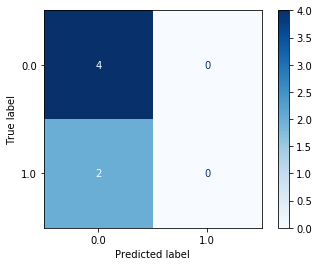

In [54]:
plot_confusion_matrix(model, X_test, y_test, include_values= True,
                                 cmap=plt.cm.Blues)

In [55]:
accuracy

0.6666666666666666

In [56]:
#Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X, y)
print(gnb.score(X_train,y_train))
predictions = gnb.predict(X_test)  # predict the target of testing samples
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.8333333333333334
Accuracy: 83.33%


E:\Anaconda\envs\CISCProject\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


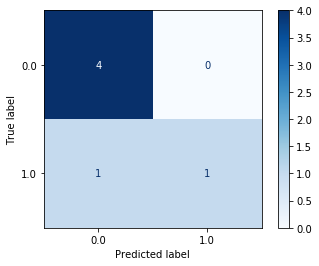

In [57]:
plot_confusion_matrix(gnb, X_test, y_test, include_values= True,
                                 cmap=plt.cm.Blues)

In [58]:
#SVM Classification Training
svm = SVC(C = .5)
svm.fit(X_train, y_train)
print(svm.score(X_train,y_train))
predictions = svm.predict(X_test)  # predict the target of testing samples
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.9166666666666666
Accuracy: 66.67%


E:\Anaconda\envs\CISCProject\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
